In [1]:
import torch
import pickle

from torchvision import transforms

# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from inertia_bVAE.models import inertiaVAE32, beta_from_normalized_beta, loss_function, reconstruction_loss, kl_divergence, prediction_loss
from data.dspritesbT import dSpriteBackgroundDatasetTime

In [2]:
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)

N = 1 * 32 * 32
M = 10

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)


for ii,_ in enumerate(normalized_beta_values):
    print(['betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])

['betanorm = 0.001 / beta = 0.1']
['betanorm = 0.005 / beta = 0.6']
['betanorm = 0.030 / beta = 3.1']
['betanorm = 0.166 / beta = 17.0']
['betanorm = 0.910 / beta = 93.2']
['betanorm = 5.000 / beta = 512.0']


In [3]:
n_latent = 4

gamma_values = np.linspace(0, 1, 6)

vae = list()
training_stats = list()
for _,beta_norm in enumerate(normalized_beta_values):

    # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
    beta_norm_str = '%0.4f' % (beta_norm)
    while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
        beta_norm_str = beta_norm_str[:-1]
        
    for _,gamma in enumerate(gamma_values):

        trainedpath = 'trained/inertiavae32_nlatent=%s_betanorm=%s_gamma=%s_dspritesT_circle_last_500K' % (beta_norm_str,n_latent,gamma)
        trainstatspath = 'trained/inertiavae32_nlatent=%s_betanorm=%s_gamma=%s_dspritesT_circle_500K.pkl' % (beta_norm_str,n_latent,gamma)

        vae.append(inertiaVAE32(n_latent = n_latent, gamma=gamma))
#     checkpoint = torch.load(trainedpath)
#     vae[ii].load_state_dict(checkpoint['model_states']['net'])
# 
#     training_stats.append(pickle.load(open(trainstatspath, 'rb')))
print(gamma_values)

[0.  0.2 0.4 0.6 0.8 1. ]


In [4]:
vae[0]

inertiaVAE32(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc_enc_mu): Linear(in_features=256, out_features=4, bias=True)
  (fc_enc_logvar): Linear(in_features=256, out_features=4, bias=True)
  (fc_dec): Linear(in_features=4, out_features=256, bias=True)
  (convT4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT1): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [5]:
dt = dSpriteBackgroundDatasetTime(transform=transforms.Resize((32,32)),
                                   shapetype='circle',data_dir='data/dsprites-dataset/')

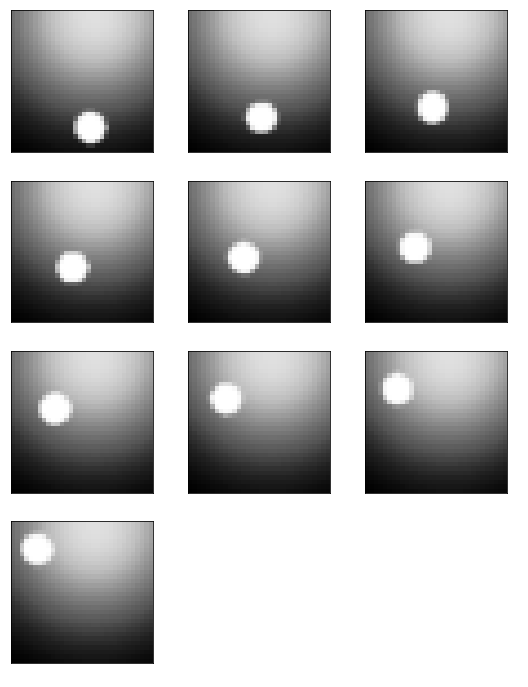

In [6]:
from data.dspritesb import show_images_grid
show_images_grid(dt[3][0])

In [7]:
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(dt, batch_size=25,shuffle=True, num_workers=4)
for i,[samples,latents] in enumerate(dataloader):
    print(samples.shape)
#     show_images_grid(samples.view(25*10,1,32,32))
    break
x = samples

torch.Size([25, 10, 1, 32, 32])


In [8]:
x.shape

torch.Size([25, 10, 1, 32, 32])

In [9]:
x.view(vae[0].n_frames*x.size(0),vae[0].img_channels,32,32).shape

torch.Size([250, 1, 32, 32])

In [10]:
x1=vae[0].conv1(x.view(vae[0].n_frames*x.size(0),vae[0].img_channels,32,32))
x1.shape
x4=vae[0].conv4(vae[0].conv3(vae[0].conv2(x1)))
x4.shape

torch.Size([250, 64, 2, 2])

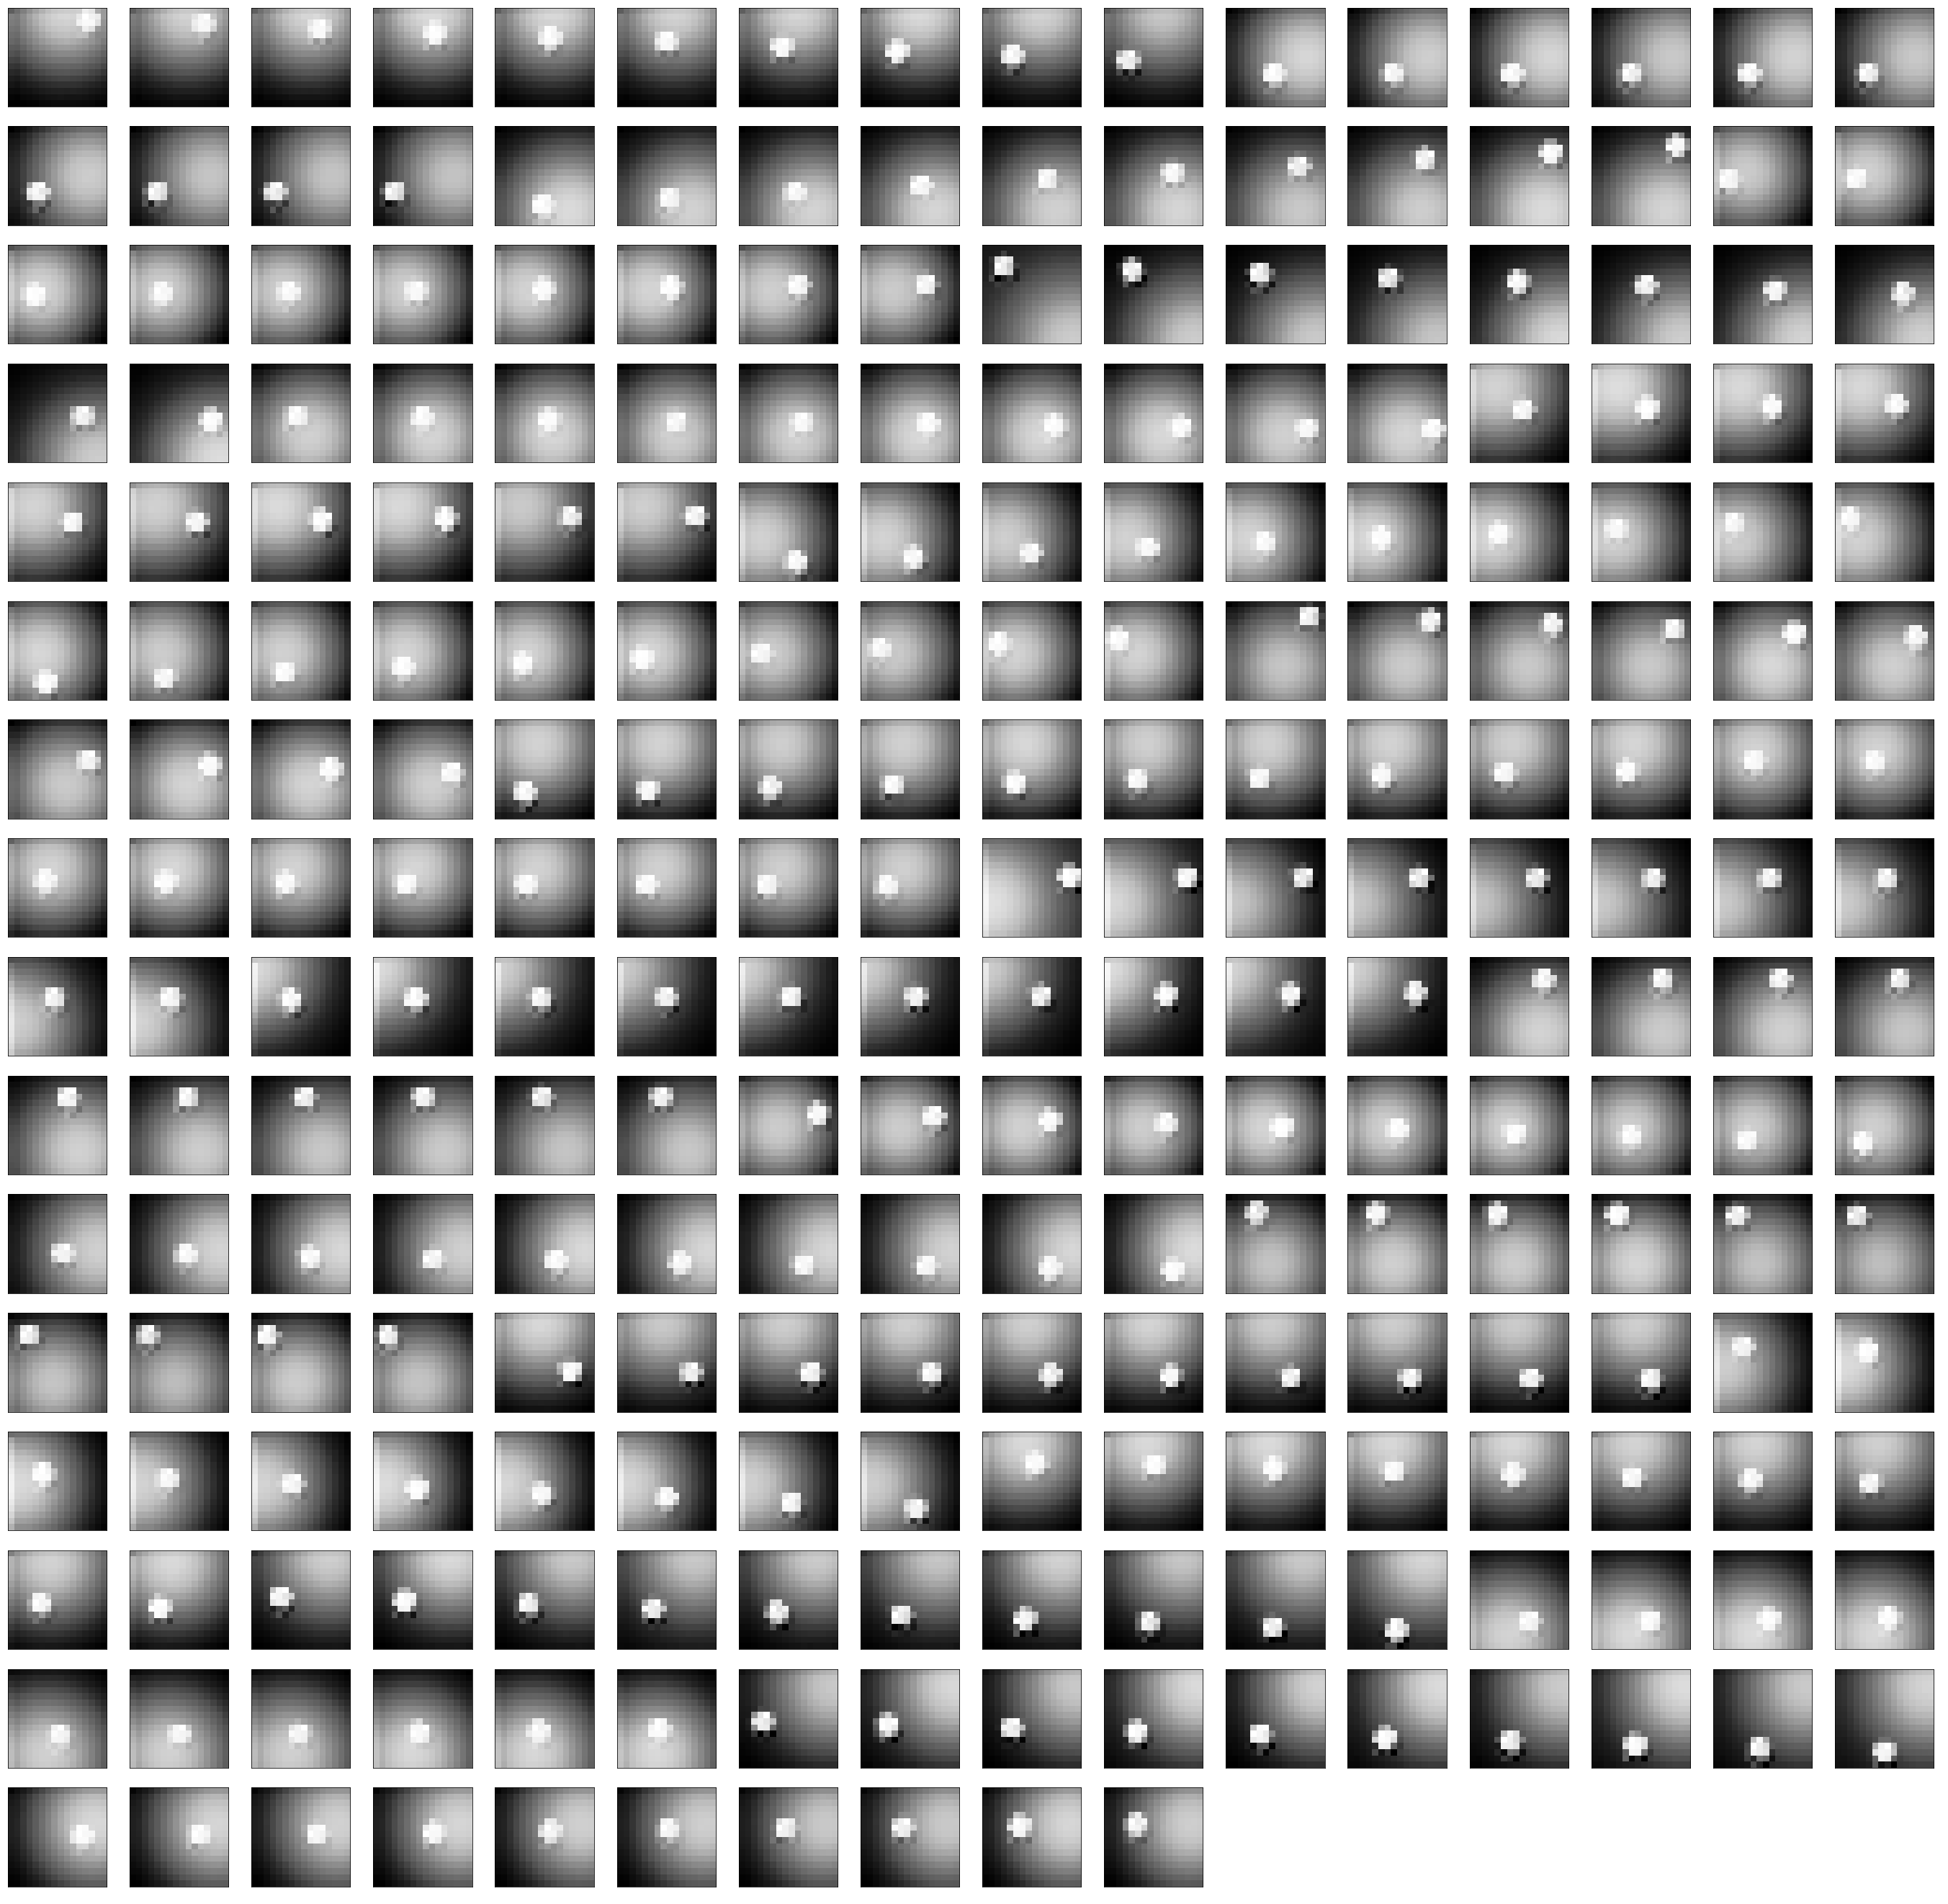

In [14]:
x1show = x1[:,0,:,:].view(-1,1,16,16).detach().numpy()
show_images_grid(x1show)

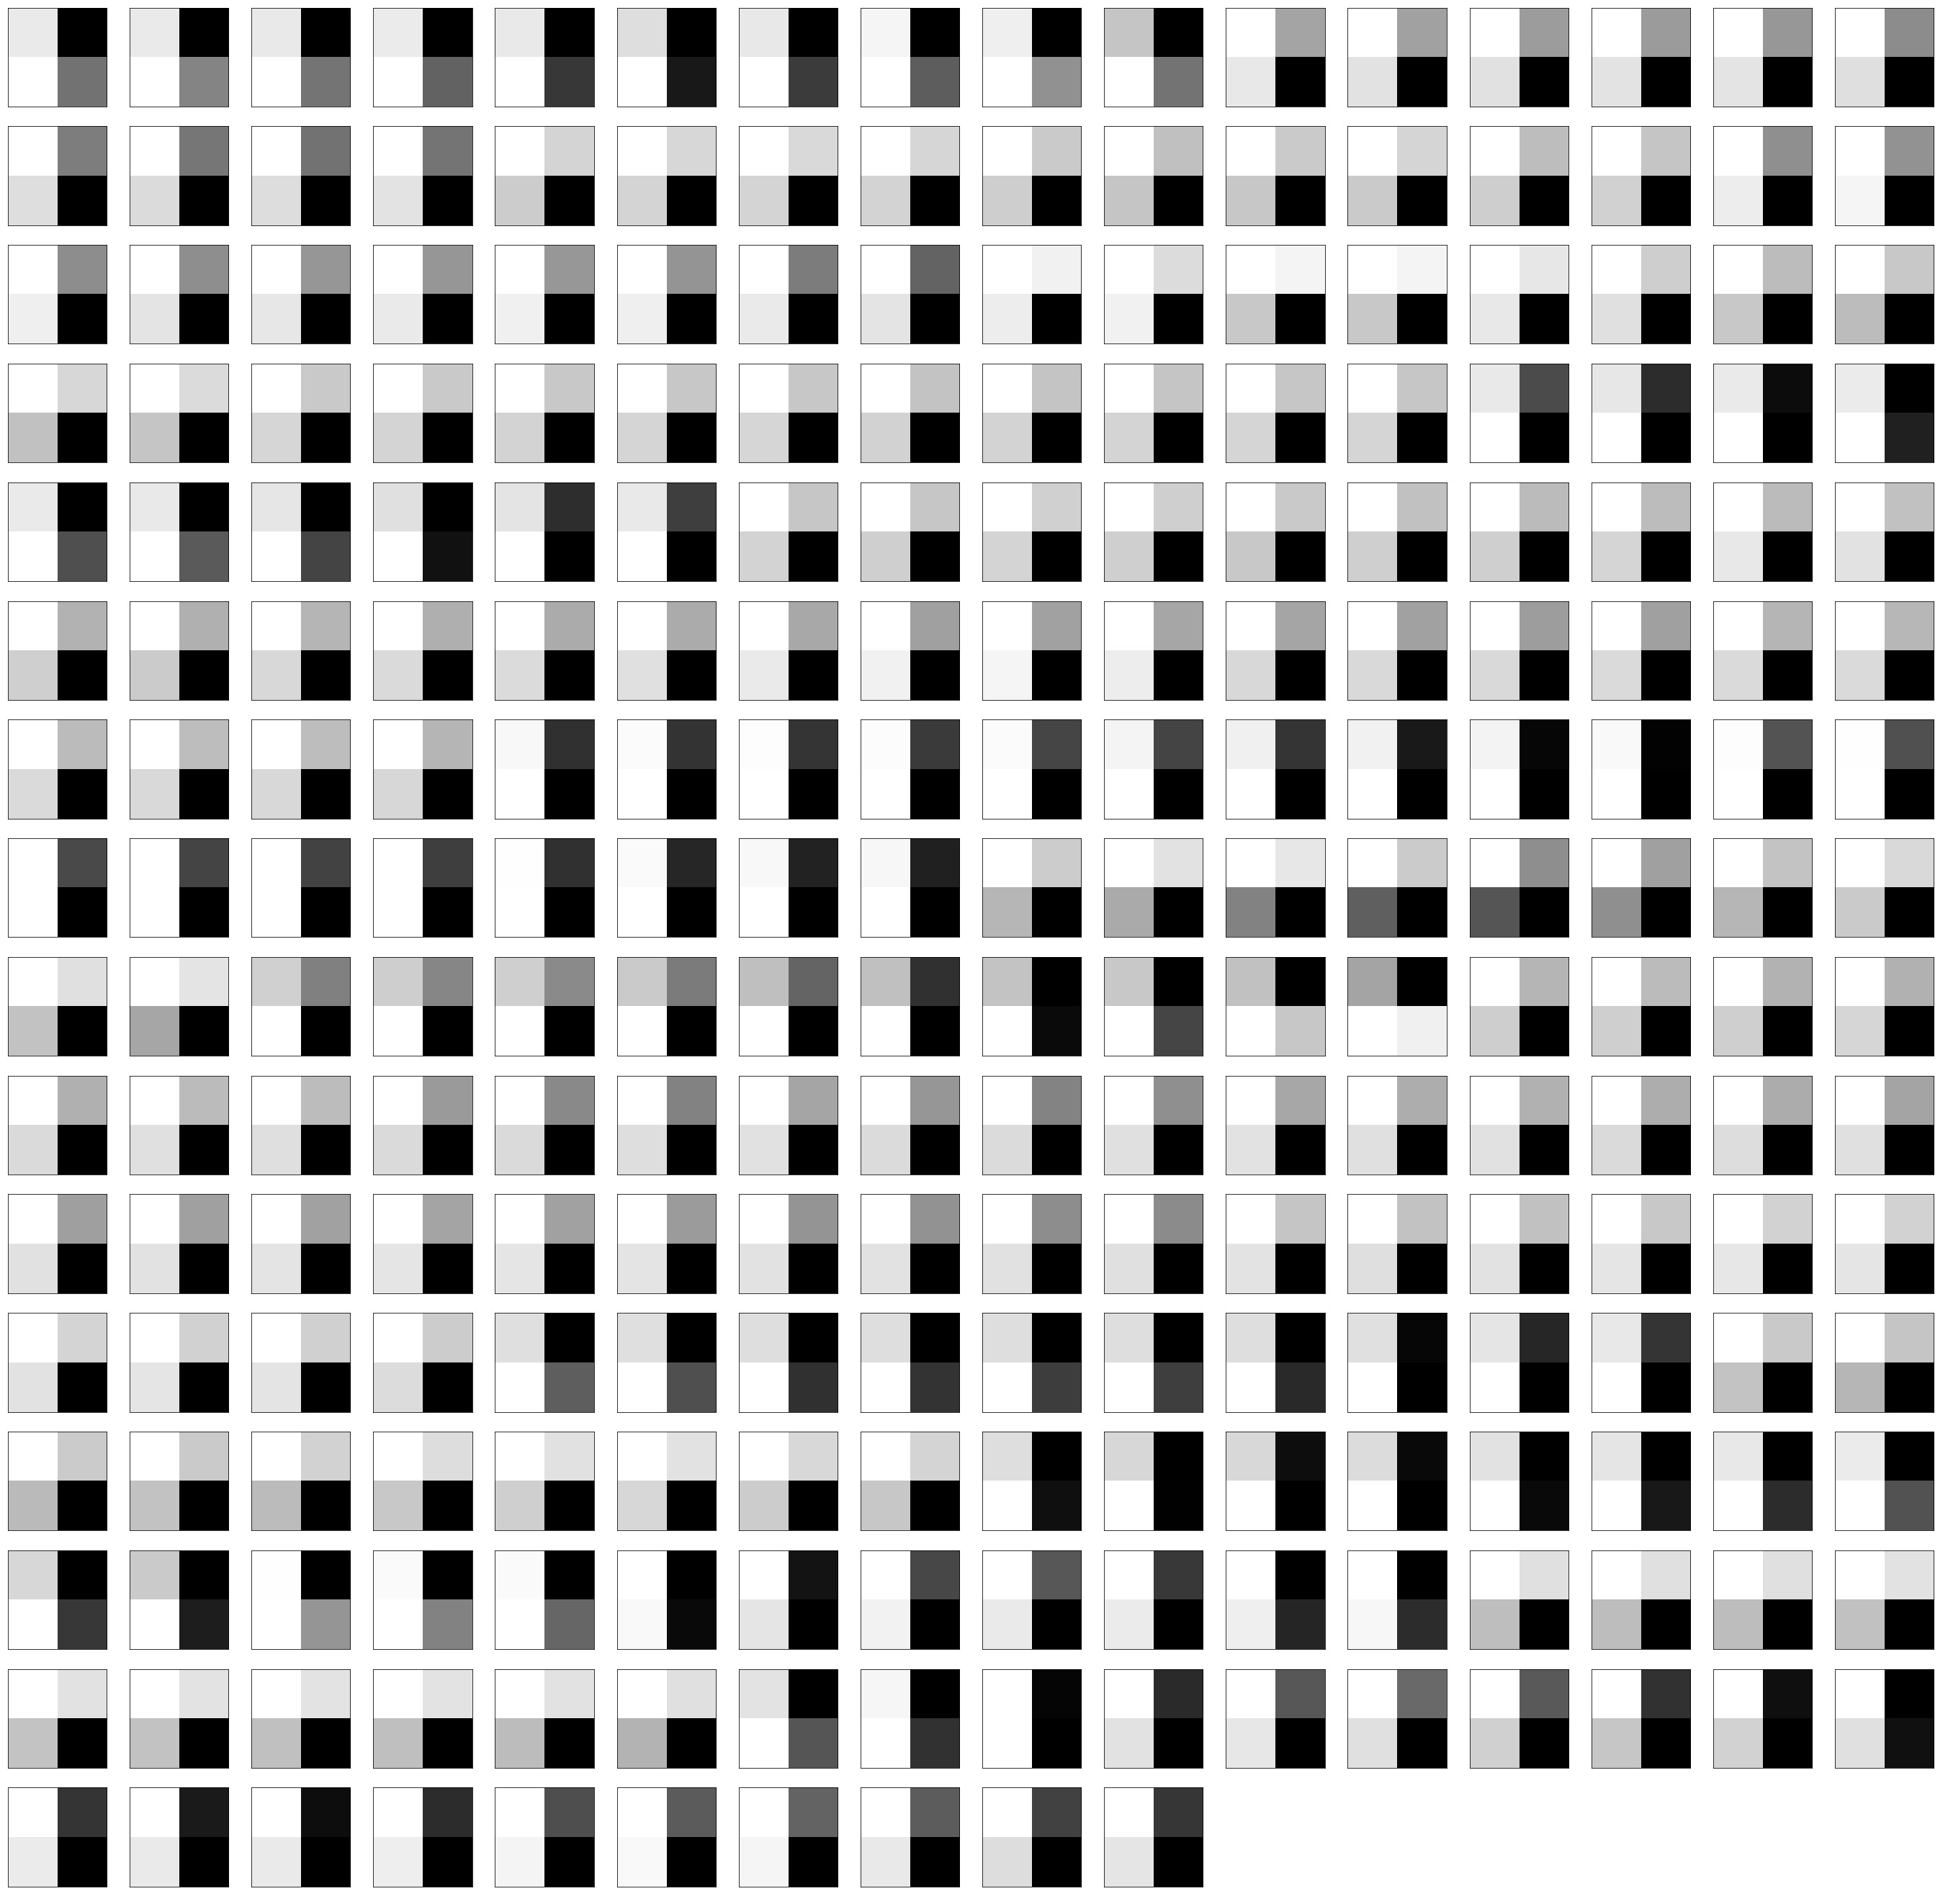

In [15]:
x4show = x4[:,0,:,:].view(-1,1,2,2).detach().numpy()
show_images_grid(x4show)

In [11]:
vae[0].fc_enc_mu(x4.view(-1,256)).shape

torch.Size([250, 4])

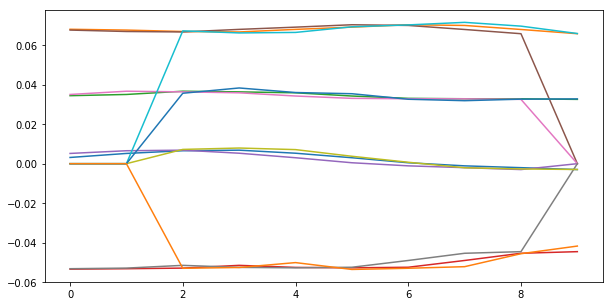

In [12]:
firstone = vae[0].fc_enc_mu(x4.view(-1,256)).view(25,10,n_latent)[:1,:,:]
firstone.shape

second = torch.zeros_like(firstone)
pred = torch.zeros_like(firstone)
second[:,:-1,:] = firstone[:,1:,:]
# second
pred[:,2:,:] = second[:,:-2,:] + (second[:,:-2,:]-firstone[:,:-2,:])
# pred[:,1:,:] = np.append(np.zeros((25,2,10)),pred[:,:-2,:],1)
pred

plt.figure(figsize=(10,5))
plt.plot(firstone.detach().numpy().reshape(-1,n_latent))
plt.plot(second.detach().numpy().reshape(-1,n_latent))
plt.plot(pred.detach().numpy().reshape(-1,n_latent))

In [23]:
gg=2
gamma = gamma_values[gg]

_,mu_enc,_,_,logvar_enc,_ = vae[0].encode(x)
# _,mu_enc,_,logvar_enc = vae[0].encode(x)
### MU's
mu_enc = mu_enc.view(-1,vae[0].n_frames-1,n_latent)
mu_enc.shape
# first mu_pred is just mu_enc
mu_pred = torch.zeros_like(mu_enc)
mu = torch.zeros_like(mu_enc)
mu_pred[:,0,:] = mu_enc[:,0,:]
# as a consequence, first mu is also just mu_enc
mu[:,0,:] = mu_pred[:,0,:]
# second mu_pred is same as first mu_pred
mu_pred[:,1,:] = mu_pred[:,0,:]
### LOGVAR's
logvar_enc = logvar_enc.view(-1,vae[0].n_frames-1,vae[0].n_latent)
# first logvar_pred is just logvar_enc
logvar_pred = torch.zeros_like(logvar_enc)
logvar = list()# torch.zeros_like(logvar_enc)
logvar_pred[:,0,:] = logvar_enc[:,0,:]
# as a consequence, first logvar is also just logvar_enc
logvar.append(logvar_pred[:,0,:])
# second logvar_pred is same as first logvar_pred
logvar_pred[:,1,:] = logvar_pred[:,0,:]

for i in range(1,vae[0].n_frames-1):
    mu[:,i,:] = (1-gamma)*mu_enc[:,i,:] + gamma*mu_pred[:,i,:]
    # variance for weighted mixture of gaussians has additional term accounting for the weighted dispersion of the means
    logvar.append((1-gamma)*logvar_enc[:,i,:] + gamma*logvar_pred[:,i,:] + \
                  (1-gamma)*(mu_enc[:,i,:]**2) + gamma*(mu_pred[:,i,:]**2) - mu[:,i,:]**2
                 )
    if i < vae[0].n_frames-2:
        mu_pred[:,i+1,:] = 1*(mu[:,i,:] - mu[:,i-1,:]) + mu[:,i,:]
        # Equally weight the variances from the previous two time steps
        # Simplified based on expansion of (0.5*logvar[:,i-1,:] + 0.5*logvar[:,i,:])**2 :
        # 0.25*logvar[:,i-1,:]**2 + 0.25*logvar[:,i,:]**2 + 0.5*logvar[:,i-1,:]*logvar[:,i,:]
        logvar_pred[:,i+1,:] = 0.5*logvar[i-1] + 0.5*logvar[i] + 0.25*(mu[:,i-1,:]**2) + \
                             0.25*(mu[:,i,:]**2) - 0.5*mu[:,i-1,:]*mu[:,i,:]
# mu1 = mu.view(-1,vae[0].n_frames,vae[0].n_latent)
# mu1.size(0)
logvar = torch.stack(logvar).permute(1,0,2)

gamma,1000*mu_enc[0,:,0],1000*mu_pred[0,:,0],1000*mu[0,:,0],1000*logvar_enc[0,:,0],1000*logvar_pred[0,:,0],1000*logvar[0,:,0]

RuntimeError: The size of tensor a (25) must match the size of tensor b (9) at non-singleton dimension 0

In [14]:
# %pdb on
recon,mu, mu_enc, mu_pred, logvar, logvar_enc, logvar_pred = vae[0].forward(x)
recon.size(),mu.size(),mu_enc.size(),mu_pred.size(),logvar.size(),logvar_enc.size(),logvar_pred.size()
# recon,mu, mu_enc, mu_pred, logvar = vae[0].forward(x)
# recon.size(),mu.size(),mu_enc.size(),mu_pred.size(),logvar.size()

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(torch.Size([25, 9, 1, 32, 32]),
 torch.Size([25, 9, 4]),
 torch.Size([25, 9, 4]),
 torch.Size([25, 9, 4]),
 torch.Size([25, 9, 4]),
 torch.Size([25, 9, 4]),
 torch.Size([25, 9, 4]))

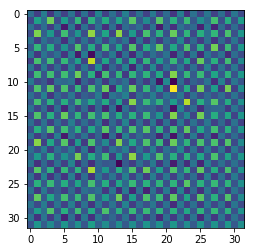

In [15]:
plt.imshow(recon[0][4][0].detach().numpy())

In [16]:
0.5*torch.sum((mu[:2,:]-mu_pred[:2,:])**2)

tensor(8.5153e-06, grad_fn=<MulBackward0>)

In [17]:
# %pdb on
recon_loss = reconstruction_loss(x, recon)
recon_loss

tensor(455.3263, grad_fn=<DivBackward0>)

In [18]:
total_kld = kl_divergence(mu, logvar)
total_kld

(tensor(0.0709, grad_fn=<SumBackward0>),
 tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020],
        grad_fn=<MeanBackward2>),
 tensor(0.0020, grad_fn=<MeanBackward0>))

In [19]:
pred_loss = prediction_loss(mu,mu_pred)
pred_loss

tensor(8.5153e-06, grad_fn=<MulBackward0>)

In [20]:
actLoss = loss_function(recon_loss=recon_loss,total_kld=total_kld[0],beta=beta[0])
actLoss

tensor(455.3336, grad_fn=<AddBackward0>)

In [21]:
torch.autograd.set_detect_anomaly(True)
actLoss.backward(retain_graph=True)

sys:1: RuntimeWarning: No forward pass information available. Enable detect anomaly during forward pass for more information.


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [25, 4]], which is output 0 of SliceBackward, is at version 9; expected version 8 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [24]:
# var_pred = torch.Tensor(size=logvar_enc.size())
torch.exp(0.5*logvar_pred)

tensor([[[1.0232, 0.9854, 1.0121, 0.9938],
         [1.0232, 0.9854, 1.0121, 0.9938],
         [1.0232, 0.9854, 1.0121, 0.9938],
         [1.0232, 0.9854, 1.0121, 0.9938],
         [1.0232, 0.9854, 1.0121, 0.9938],
         [1.0232, 0.9854, 1.0121, 0.9938],
         [1.0232, 0.9854, 1.0121, 0.9938],
         [1.0232, 0.9854, 1.0121, 0.9938],
         [1.0232, 0.9854, 1.0121, 0.9938]],

        [[1.0219, 0.9860, 1.0134, 0.9922],
         [1.0219, 0.9860, 1.0134, 0.9922],
         [1.0219, 0.9860, 1.0134, 0.9922],
         [1.0219, 0.9860, 1.0134, 0.9922],
         [1.0219, 0.9860, 1.0134, 0.9922],
         [1.0219, 0.9860, 1.0134, 0.9922],
         [1.0219, 0.9860, 1.0134, 0.9922],
         [1.0219, 0.9860, 1.0134, 0.9922],
         [1.0219, 0.9860, 1.0134, 0.9922]],

        [[1.0215, 0.9859, 1.0112, 0.9927],
         [1.0215, 0.9859, 1.0112, 0.9927],
         [1.0215, 0.9859, 1.0112, 0.9927],
         [1.0215, 0.9859, 1.0112, 0.9927],
         [1.0215, 0.9859, 1.0112, 0.9927],
       

In [23]:
gamma*mu_enc[:,i,:]**2

tensor([[7.8814e-04, 6.2775e-04, 1.1553e-05, 9.4888e-05],
        [7.1090e-04, 6.3162e-04, 1.7530e-05, 8.1331e-05],
        [8.0197e-04, 8.0676e-04, 1.9960e-05, 1.1578e-04],
        [8.0491e-04, 6.8026e-04, 2.8268e-05, 8.2849e-05],
        [7.3066e-04, 5.6832e-04, 1.3409e-05, 8.7664e-05],
        [7.4866e-04, 6.2079e-04, 1.1775e-05, 9.6462e-05],
        [8.0454e-04, 6.7925e-04, 5.8495e-06, 8.5711e-05],
        [8.2935e-04, 6.2708e-04, 1.7527e-05, 8.2737e-05],
        [6.1201e-04, 6.0418e-04, 2.6627e-05, 6.1116e-05],
        [7.5103e-04, 7.4002e-04, 3.9588e-05, 1.2135e-04],
        [7.7766e-04, 6.5456e-04, 1.0896e-05, 1.0058e-04],
        [8.3907e-04, 5.8840e-04, 1.1900e-05, 9.4323e-05],
        [7.3174e-04, 6.3612e-04, 1.2470e-05, 9.1666e-05],
        [7.3350e-04, 7.9794e-04, 3.5777e-05, 1.1401e-04],
        [7.8004e-04, 6.8262e-04, 1.7834e-05, 9.7761e-05],
        [7.8557e-04, 6.6302e-04, 1.6626e-05, 1.0343e-04],
        [7.9286e-04, 6.3693e-04, 2.5137e-05, 9.9507e-05],
        [7.416

In [23]:
# from main.py
from solver import Solver
import argparse

def str2bool(v):
    # codes from : https://stackoverflow.com/questions/15008758/parsing-boolean-values-with-argparse

    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

parser = argparse.ArgumentParser(description='inertia bVAE (dynamic beta VAE with representational inertia)')

parser.add_argument('--model', default='inertiaVAE32', type=str, help='which model to train (inertiaVAE32, inertiaVAE64))')

parser.add_argument('--seed', default=1, type=int, help='random seed')
parser.add_argument('--cuda', default=True, type=str2bool, help='enable cuda')
parser.add_argument('--batch_size', default=64, type=int, help='batch size')
parser.add_argument('--shuffle', default=True, type=str2bool, help='shuffle training data')
parser.add_argument('--max_iter', default=500000, type=int, help='number of training iterations')

parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
parser.add_argument('--n_latent', default=4, type=int, help='dimension of the latent code')
parser.add_argument('--img_channels', default=1, type=int, help='number of image channels')

parser.add_argument('--beta', default=1, type=float, help='beta for the beta VAE with representational inertia')
parser.add_argument('--beta_is_normalized', default=True, type=str2bool, help='flag whether input beta should be interpreted as normalized beta (default) or as unnormalized beta')
parser.add_argument('--gamma', default=1, type=float, help='gamma hyperparameter for the prediction contribution to inertia')

parser.add_argument('--dset_dir', default='data', type=str, help='dataset directory')
parser.add_argument('--dataset', default='dsprites_circle', type=str, help='dataset name')
parser.add_argument('--image_size', default=32, type=int, help='image size. now only (32,32) is supported')
parser.add_argument('--num_workers', default=6, type=int, help='dataloader num_workers')

parser.add_argument('--trainstats_gather_step', default=100, type=int, help='numer of iterations after which training stats are gathered and stored')
parser.add_argument('--trainstats_dir', default='trainstats', type=str, help='training statistics directory')

parser.add_argument('--display_step', default=10, type=int, help='number of iterations after which loss data is printed and visdom is updated')

parser.add_argument('--save_step', default=2000, type=int, help='number of iterations after which a checkpoint is saved')

parser.add_argument('--ckpt_dir', default='checkpoints', type=str, help='checkpoint directory')
parser.add_argument('--load_last_checkpoint', default=True, type=str2bool, help='load previous checkpoint if it exists')

_StoreAction(option_strings=['--load_last_checkpoint'], dest='load_last_checkpoint', nargs=None, const=None, default=True, type=<function str2bool at 0x7f0d7fcd5510>, choices=None, help='load previous checkpoint if it exists', metavar=None)

In [24]:
args = parser.parse_known_args()[0]

In [25]:
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [26]:
net = Solver(args)

=> loaded checkpoint 'checkpoints/inertiavae32_nlatent=4_betanorm=1_gamma=1_dsprites_circle_last (iter 2000)'


In [27]:
net.train(plotmode=True)

  0%|          | 0/500000 [00:00<?, ?it/s]

RuntimeError: expected backend CUDA and dtype Float but got backend CPU and dtype Float

In [38]:
import importlib
importlib.reload(models)
from models import inertiaVAE32, reconstruction_loss, prediction_loss
importlib.reload(solver)
from solver import Solver

NameError: name 'models' is not defined

In [ ]:
show_images_grid(dt[200000][0])

In [25]:
pwd

'/home/zaharia/projects/dgm/src/inertia_AE'